In [ ]:
import numpy as np
from scipy.integrate import dblquad,quad,nquad
import math
from numba import jit
from functools import lru_cache
import vegas


me=0.511
e=0.303
Z=57
l=10
fact_l=math.factorial(abs(l))
# 这里sigma是坐标空间的
sigma_perp=10
sigma_z=5
P_z=5
b_perp=np.array([0,50,0])

# 定义 2x2 单位矩阵和泡利矩阵
I_2 = np.eye(2, dtype=np.complex128)
I_4 = np.eye(4, dtype=np.complex128)
sigma1 = np.array([[0, 1], [1, 0]], dtype=np.complex128)
sigma2 = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
sigma3 = np.array([[1, 0], [0, -1]], dtype=np.complex128)

# 定义 Gamma 矩阵
gamma0 = np.block([[I_2, np.zeros((2, 2))], [np.zeros((2, 2)), -I_2]])
gamma1 = np.block([[np.zeros((2, 2)), sigma1], [-sigma1, np.zeros((2, 2))]])
gamma2 = np.block([[np.zeros((2, 2)), sigma2], [-sigma2, np.zeros((2, 2))]])
gamma3 = np.block([[np.zeros((2, 2)), sigma3], [-sigma3, np.zeros((2, 2))]])


@jit(nopython=True, cache=True)
def w(theta,phi,s):
    res=np.array([[np.exp(-1j*phi/2)*np.cos((theta+(1/2-s)*np.pi)/2)], [np.exp(1j*phi/2)*np.sin((theta+(1/2-s)*np.pi)/2)]], dtype=np.complex128)
    return res


@jit(nopython=True, cache=True)
def w_dagger(theta,phi,s):
    res=np.array([np.exp(1j*phi/2)*np.cos((theta+(1/2-s)*np.pi)/2), np.exp(-1j*phi/2)*np.sin((theta+(1/2-s)*np.pi)/2)], dtype=np.complex128)
    return res

@jit(nopython=True, cache=True)
def u(epsilon, theta, phi, s):
    w_component = w(theta, phi, s)
    upper_part = np.sqrt(epsilon + me) * w_component
    lower_part = 2 * np.sqrt(epsilon - me) * s * w_component
    res = np.empty((len(upper_part) + len(lower_part), upper_part.shape[1]), dtype=np.complex128)
    res[:len(upper_part), :] = upper_part
    res[len(upper_part):, :] = lower_part
    return res


@jit(nopython=True, cache=True)
def u_f(epsilon_f, theta_f, phi_f, s_f):
    w_dagger_component= w_dagger(theta_f, phi_f, s_f)
    component_1 = np.sqrt(epsilon_f + me) * w_dagger_component
    component_2 = -2 * np.sqrt(epsilon_f - me) * s_f * w_dagger_component
    res = np.zeros(2 * len(component_1), dtype=np.complex128) 
    res[:len(component_1)] = component_1
    res[len(component_1):] = component_2
    return res

@jit(nopython=True, cache=True)
def photon_polar(lamb,theta_k,phi_k):
    res=np.array([0,
                     1/np.sqrt(2)*(np.cos(theta_k)*np.cos(phi_k)-1j*lamb*np.sin(phi_k)),
                     1/np.sqrt(2)*(np.cos(theta_k)*np.sin(phi_k)-1j*lamb*np.cos(phi_k)),
                     1/np.sqrt(2)*np.sin(theta_k)], dtype=np.complex128)
    return res



@jit(nopython=True, cache=True)
def four_vec(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    res=np.array([energy,p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi),p*np.cos(theta)])
    return res

@jit(nopython=True, cache=True)
def three_vec(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    res=np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi),p*np.cos(theta)])
    return res

@jit(nopython=True, cache=True)
def two_vec_mod(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    res=np.sqrt(np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi)])@np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi)]))
    return res

@jit(nopython=True, cache=True)
def four_vec_slash(energy,m,theta,phi):
    four_vec_=four_vec(energy,m,theta,phi)
    res= four_vec_[0]*gamma0
    res +=-four_vec_[1]*gamma1
    res +=-four_vec_[2]*gamma2
    res +=-four_vec_[3]*gamma3
    return res

@jit(nopython=True, cache=True)
def photon_polar_slash(lamb,theta_k,phi_k):
    photon_polar_=photon_polar(lamb,theta_k,phi_k)
    res= photon_polar_[0]*gamma0
    res +=-photon_polar_[1]*gamma1
    res +=-photon_polar_[2]*gamma2
    res +=-photon_polar_[3]*gamma3
    return res


@jit(nopython=True, cache=True)
def Phi_cap(epsilon, theta, phi, l):
    two_vec_mod_=two_vec_mod(epsilon,me,theta,phi)
    res= (4*np.pi)**(3/4)*np.sqrt(epsilon)*sigma_perp*np.sqrt(sigma_z)*(sigma_perp*two_vec_mod_)**(abs(l))/np.sqrt(fact_l)\
       *np.exp(-sigma_perp**2*two_vec_mod_**2/2)*np.exp(-sigma_z**2*(np.sqrt(epsilon**2-me**2)*np.cos(theta)-P_z)**2/2)*np.exp(1j*l*phi)
    return res
        




def var_L(s, epsilon_f, theta_f, phi_f, s_f, omega, theta_k, phi_k, lamb, N_theta=100, N_phi=300):
    """ 使用梯形法计算复数二重积分 """
    # 生成 θ 和 φ 的均匀网格点
    theta_vals = np.linspace(0, 0.15, N_theta)  # θ 从 0 到 π
    phi_vals   = np.linspace(0, 2*np.pi, N_phi)  # φ 从 0 到 2π
    # 计算函数值的网格存放
    F_vals = np.zeros((N_theta, N_phi), dtype=np.complex128)  # 复数数组

    photon_polar_slash_=photon_polar_slash(lamb,theta_k,phi_k)
    four_vec_slash_k=four_vec_slash(omega,0,theta_k,phi_k)
    three_vec_f=three_vec(epsilon_f,me,theta_f,phi_f)
    three_vec_k=three_vec(omega,0,theta_k,phi_k)
    u_f_=u_f(epsilon_f,theta_f,phi_f,s_f)
    four_vec_slash_f=four_vec_slash(epsilon_f,me,theta_f,phi_f)
    epsilon=epsilon_f+omega

    @jit(nopython=True, cache=True)
    def var_L_pre(theta_,phi_):
        three_vec_i=three_vec(epsilon,me,theta_,phi_)
        M_res=(4*np.pi)**(3/2)*Z*e**3/((three_vec_f+three_vec_k-three_vec_i)@(three_vec_f+three_vec_k-three_vec_i))*\
                            u_f_@\
                            (1/(2*(omega*epsilon_f-three_vec_k@three_vec_f))*photon_polar_slash_@\
                            (four_vec_slash_f+four_vec_slash_k+me*I_4)@gamma0\
                            +\
                            1/(-2*(omega*epsilon-three_vec_k@three_vec_i))*gamma0@\
                            (four_vec_slash(epsilon,me,theta_,phi_)-four_vec_slash_k+me*I_4)@photon_polar_slash_)@\
                            u(epsilon,theta_,phi_,s)

        three_vec_i=three_vec_i.astype(np.complex128)
        res=np.pi/(2*np.pi)**(3)*np.sin(theta_)*Phi_cap(epsilon,theta_,phi_,l)*np.exp(-1j*b_perp@three_vec_i)*M_res[0]
        return res

    # 遍历网格, 计算 var_L_pre
    for i, theta_for in enumerate(theta_vals):
        for j, phi_for in enumerate(phi_vals):
            F_vals[i, j] = var_L_pre(theta_for, phi_for)
    # **第一步: 先对 phi 方向进行梯形法积分**
    int_phi = np.trapz(F_vals, phi_vals, axis=1)  # 对每个 theta 积分
    # **第二步: 再对 theta 方向进行梯形法积分**
    integral = np.trapz(int_phi, theta_vals)
    
    return integral




omega0=2
# 定义积分域
epsilon_f_min, epsilon_f_max =me+0.001 , np.sqrt(P_z**2+me**2)-omega0+2
theta_f_min, theta_f_max = 0, np.pi
phi_f_min, phi_f_max = 0, 2 * np.pi
theta_k_min, theta_k_max = 0, np.pi
phi_k_min, phi_k_max = 0, 2 * np.pi

# 定义被积函数 (注意: vegas 传递的是一个包含5个值的输入 x)
def integrand(x):
    epsilon_f, theta_f, phi_f, theta_k, phi_k = x  # 解包变量

    # 计算 var_L
    var_l = var_L(s=1, epsilon_f=epsilon_f, theta_f=theta_f,
                  phi_f=phi_f, s_f=1, omega=omega0, 
                  theta_k=theta_k, phi_k=phi_k, lamb=1)
    
    # 返回被积函数值
    return np.sin(theta_k) * np.sin(theta_f) * abs(var_l)**2  

# 定义 vegas 积分器
integ = vegas.Integrator([
    [epsilon_f_min, epsilon_f_max],   # epsilon_f
    [theta_f_min, theta_f_max],       # theta_f
    [phi_f_min, phi_f_max],           # phi_f
    [theta_k_min, theta_k_max],       # theta_k
    [phi_k_min, phi_k_max]            # phi_k
])

# 训练阶段 (可以调整 nitn 次数)
integ(integrand, nitn=5, neval=10)

# 计算积分 (最终评估)
result = integ(integrand, nitn=3, neval=100)

# 输出结果
print("积分结果:", result, "误差:", result.sdev)


#print(var_L(0.5,1.026,np.pi/2,np.pi/3,0.5,4,np.pi/3,np.pi/3,1))

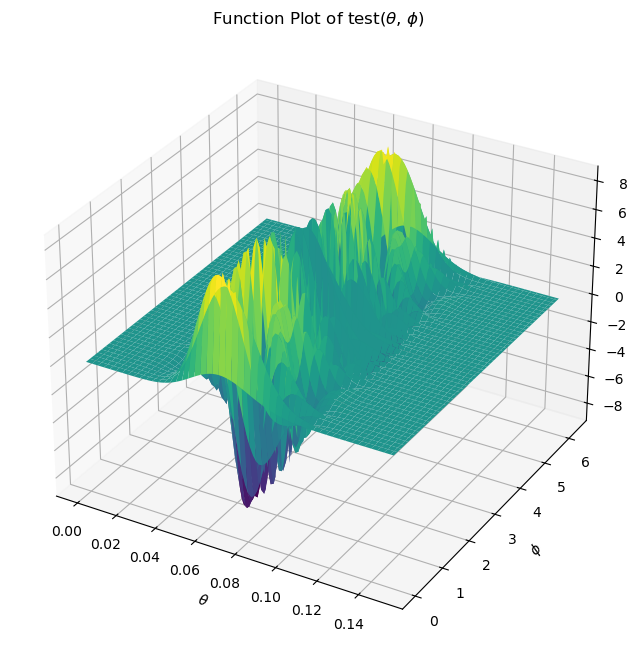

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

@jit(nopython=True, cache=True)
def M(epsilon,theta,phi,s,epsilon_f,theta_f,phi_f,s_f,omega,theta_k,phi_k,lamb):

    photon_polar_slash_=photon_polar_slash(lamb,theta_k,phi_k)
    four_vec_slash_k=four_vec_slash(omega,0,theta_k,phi_k)
    three_vec_i=three_vec(epsilon,me,theta,phi)
    three_vec_f=three_vec(epsilon_f,me,theta_f,phi_f)
    three_vec_k=three_vec(omega,0,theta_k,phi_k)

    res=(4*np.pi)**(3/2)*Z*e**3/((three_vec_f+three_vec_k-three_vec_i)@(three_vec_f+three_vec_k-three_vec_i))*\
                        u_f(epsilon_f,theta_f,phi_f,s_f)@\
                        (1/(2*(omega*epsilon_f-three_vec_k@three_vec_f))*photon_polar_slash_@\
                        (four_vec_slash(epsilon_f,me,theta_f,phi_f)+four_vec_slash_k+me*I_4)@gamma0\
                        +\
                        1/(-2*(omega*epsilon-three_vec_k@three_vec_i))*gamma0@\
                        (four_vec_slash(epsilon,me,theta,phi)-four_vec_slash_k+me*I_4)@photon_polar_slash_)@\
                        u(epsilon,theta,phi,s)
    return res[0]



@jit(nopython=True, cache=True)
def var_L_pre_plt(theta,phi,s,epsilon_f,theta_f,phi_f,s_f,omega,theta_k,phi_k,lamb):
    epsilon=epsilon_f+omega
    three_vec_res = three_vec(epsilon, me, theta, phi).astype(np.complex128)
    res=np.pi/(2*np.pi)**(3)*np.sin(theta)*Phi_cap(epsilon,theta,phi,l)*np.exp(-1j*b_perp@three_vec_res)\
        *M(epsilon,theta,phi,s,epsilon_f,theta_f,phi_f,s_f,omega,theta_k,phi_k,lamb)
    return res

def test(theta,phi):
    res=var_L_pre_plt(theta,phi,0.5,1.026,np.pi/3,np.pi/3,0.5,4,np.pi/3,np.pi/3,1)
    return res.imag


# 生成 theta 和 phi 的数据
theta_vals = np.linspace(0, 0.15, 100)  # 从 0 到 pi
phi_vals = np.linspace(0, 2*np.pi, 100)  # 从 0 到 2*pi
theta, phi = np.meshgrid(theta_vals, phi_vals)

# 计算 test 函数值
# 用 numpy 的 `frompyfunc` 确保 `test` 逐元素计算
z = np.frompyfunc(test, 2, 1)(theta, phi).astype(np.float64)  # 关键部分


# 创建图形
fig = plt.figure(figsize=(10, 8))

# 选择绘制方式(取消注释你想要的)

## 方式 1: 3D 曲面图
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(theta, phi, z, cmap='viridis')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_zlabel(r'test($\theta$, $\phi$)')

## 方式 2: 等高线图(如果需要 2D 视图)
# ax = fig.add_subplot(111)
# contour = ax.contourf(theta, phi, z, levels=50, cmap='viridis')
# fig.colorbar(contour)
# ax.set_xlabel(r'$\theta$')
# ax.set_ylabel(r'$\phi$')

plt.title("Function Plot of test($\\theta$, $\\phi$)")
plt.show()
